# timeseries

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
# Disable caching for performance testing
vbt.defaults.caching = False

In [4]:
index = pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
], freq='D')
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float32)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [5]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [6]:
# Test index frequency
print(ts.vbt.timeseries.freq)
print(ts['a'].vbt.timeseries.freq)
print(ts.vbt.timeseries(freq='2D').freq)
print(ts['a'].vbt.timeseries(freq='2D').freq)
print(pd.Series([1, 2, 3]).vbt.timeseries.freq)
print(pd.Series([1, 2, 3]).vbt.timeseries(freq='3D').freq)
print(pd.Series([1, 2, 3]).vbt.timeseries(freq=np.timedelta64(4, 'D')).freq)

1 days 00:00:00
1 days 00:00:00
2 days 00:00:00
2 days 00:00:00
None
3 days 00:00:00
4 days 00:00:00


In [7]:
print(ts.fillna(-1))
%timeit big_ts.fillna(-1)

print(ts.vbt.timeseries.fillna(-1))
%timeit big_ts.vbt.timeseries.fillna(-1)

              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
10.3 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0 -1.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0 -1.0
2018-01-04  4.0  2.0  2.0
2018-01-05 -1.0  1.0  1.0
5.14 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
print(ts.shift(3))
%timeit big_ts.shift(3)

print(ts.vbt.timeseries.fshift(3))
%timeit big_ts.vbt.timeseries.fshift(3)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
3.58 ms ± 445 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  NaN  NaN  NaN
2018-01-03  NaN  NaN  NaN
2018-01-04  1.0  NaN  1.0
2018-01-05  2.0  4.0  2.0
3.27 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
print(ts.diff())
%timeit big_ts.diff()

print(ts.vbt.timeseries.diff())
%timeit big_ts.vbt.timeseries.diff()

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
6.32 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  1.0 -1.0  NaN
2018-01-04  1.0 -1.0  NaN
2018-01-05  NaN -1.0 -1.0
5.41 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
print(ts.pct_change())
%timeit big_ts.pct_change()

print(ts.vbt.timeseries.pct_change())
%timeit big_ts.vbt.timeseries.pct_change()

                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  0.0
2018-01-04  0.333333 -0.333333  0.0
2018-01-05  0.000000 -0.500000 -0.5
493 ms ± 89.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b    c
2018-01-01       NaN       NaN  NaN
2018-01-02  1.000000       NaN  1.0
2018-01-03  0.500000 -0.250000  NaN
2018-01-04  0.333333 -0.333333  NaN
2018-01-05       NaN -0.500000 -0.5
7.86 ms ± 911 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
print(ts.ffill())
%timeit big_ts.ffill()

print(ts.vbt.timeseries.ffill())
%timeit big_ts.vbt.timeseries.ffill()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
7.19 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  2.0
2018-01-04  4.0  2.0  2.0
2018-01-05  4.0  1.0  1.0
11.5 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
print(ts.product())
%timeit big_ts.product()

print(ts.vbt.timeseries.product())
%timeit big_ts.vbt.timeseries.product()

a    24.0
b    24.0
c     4.0
dtype: float32
7.19 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    24.0
b    24.0
c     4.0
dtype: float64
4.48 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
print(ts.cumsum())
%timeit big_ts.cumsum()

print(ts.vbt.timeseries.cumsum())
%timeit big_ts.vbt.timeseries.cumsum()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
19.1 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   3.0   4.0  3.0
2018-01-03   6.0   7.0  NaN
2018-01-04  10.0   9.0  5.0
2018-01-05   NaN  10.0  6.0
9.76 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print(ts.cumprod())
%timeit big_ts.cumprod()

print(ts.vbt.timeseries.cumprod())
%timeit big_ts.vbt.timeseries.cumprod()

               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
11.9 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
               a     b    c
2018-01-01   1.0   NaN  1.0
2018-01-02   2.0   4.0  2.0
2018-01-03   6.0  12.0  NaN
2018-01-04  24.0  24.0  4.0
2018-01-05   NaN  24.0  4.0
8.61 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print(ts.rolling(2).min())
%timeit big_ts.rolling(2).min()

print(ts.vbt.timeseries.rolling_min(2))
%timeit big_ts.vbt.timeseries.rolling_min(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
45.7 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.0  NaN  1.0
2018-01-03  2.0  3.0  NaN
2018-01-04  3.0  2.0  NaN
2018-01-05  NaN  1.0  1.0
15.6 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
print(ts.rolling(2).max())
%timeit big_ts.rolling(2).max()

print(ts.vbt.timeseries.rolling_max(2))
%timeit big_ts.vbt.timeseries.rolling_max(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
48.3 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  2.0  NaN  2.0
2018-01-03  3.0  4.0  NaN
2018-01-04  4.0  3.0  NaN
2018-01-05  NaN  2.0  2.0
21.3 ms ± 4.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
print(ts.rolling(2).mean())
%timeit big_ts.rolling(2).mean()

print(ts.vbt.timeseries.rolling_mean(2))
%timeit big_ts.vbt.timeseries.rolling_mean(2)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
34.1 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  3.5  NaN
2018-01-04  3.5  2.5  NaN
2018-01-05  NaN  1.5  1.5
17.3 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print(ts.rolling(2).std())
%timeit big_ts.rolling(2).std()

print(ts.vbt.timeseries.rolling_std(2))
%timeit big_ts.vbt.timeseries.rolling_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
64.3 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107       NaN
2018-01-04  0.707107  0.707107       NaN
2018-01-05       NaN  0.707107  0.707107
19.3 ms ± 762 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
print(ts.ewm(span=2, min_periods=2).mean())
%timeit big_ts.ewm(span=2, min_periods=2).mean()

print(ts.vbt.timeseries.ewm_mean(2))
%timeit big_ts.vbt.timeseries.ewm_mean(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000       NaN  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
97.8 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  1.750000       NaN  1.750000
2018-01-03  2.615385  3.250000  1.750000
2018-01-04  3.550000  2.384615  1.967742
2018-01-05  3.550000  1.450000  1.267857
14.5 ms ± 910 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
print(ts.ewm(span=2, min_periods=2).std())
%timeit big_ts.ewm(span=2, min_periods=2).std()

print(ts.vbt.timeseries.ewm_std(2))
%timeit big_ts.vbt.timeseries.ewm_std(2)

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
546 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.919866  0.707107  0.707107
2018-01-04  1.059753  0.919866  0.367607
2018-01-05  1.059753  1.059753  0.684914
27.2 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
print(ts.expanding().min())
%timeit big_ts.expanding().min()

print(ts.vbt.timeseries.expanding_min())
%timeit big_ts.vbt.timeseries.expanding_min()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
52.6 ms ± 943 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.0  4.0  1.0
2018-01-03  1.0  3.0  1.0
2018-01-04  1.0  2.0  1.0
2018-01-05  1.0  1.0  1.0
8.97 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
print(ts.expanding().max())
%timeit big_ts.expanding().max()

print(ts.vbt.timeseries.expanding_max())
%timeit big_ts.vbt.timeseries.expanding_max()

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
50.9 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  4.0  2.0
2018-01-04  4.0  4.0  2.0
2018-01-05  4.0  4.0  2.0
9 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
print(ts.expanding().mean())
%timeit big_ts.expanding().mean()

print(ts.vbt.timeseries.expanding_mean())
%timeit big_ts.vbt.timeseries.expanding_mean()

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
31.2 ms ± 429 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
17.1 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print(ts.expanding().std())
%timeit big_ts.expanding().std()

print(ts.vbt.timeseries.expanding_std())
%timeit big_ts.vbt.timeseries.expanding_std()

                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
62.3 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  1.000000  0.707107  0.707107
2018-01-04  1.290994  1.000000  0.577350
2018-01-05  1.290994  1.290994  0.577350
18.8 ms ± 977 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
pd_nanmean_nb = njit(lambda x: np.nanmean(x))
nanmean_nb = njit(lambda col, i, x: np.nanmean(x))
nanmean_matrix_nb = njit(lambda i, x: np.nanmean(x))

In [26]:
print(ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.rolling(2, min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.timeseries.rolling_apply(2, nanmean_nb))
%timeit big_ts.vbt.timeseries.rolling_apply(2, nanmean_nb)

print(ts.vbt.timeseries.rolling_apply(3, nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.rolling_apply(3, nanmean_matrix_nb, on_matrix=True)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
442 ms ± 6.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  1.5  4.0  1.5
2018-01-03  2.5  3.5  2.0
2018-01-04  3.5  2.5  2.0
2018-01-05  4.0  1.5  1.5
68.2 ms ± 860 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.750000  2.750000  2.750000
2018-01-05  2.285714  2.285714  2.285714
7.5 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
print(ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True))
%timeit big_ts.expanding(min_periods=1).apply(pd_nanmean_nb, raw=True)

print(ts.vbt.timeseries.expanding_apply(nanmean_nb))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_nb)

print(ts.vbt.timeseries.expanding_apply(nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.expanding_apply(nanmean_matrix_nb, on_matrix=True)

              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
1.61 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b         c
2018-01-01  1.0  NaN  1.000000
2018-01-02  1.5  4.0  1.500000
2018-01-03  2.0  3.5  1.500000
2018-01-04  2.5  3.0  1.666667
2018-01-05  2.5  2.5  1.500000
929 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                   a         b         c
2018-01-01  1.000000  1.000000  1.000000
2018-01-02  2.000000  2.000000  2.000000
2018-01-03  2.285714  2.285714  2.285714
2018-01-04  2.400000  2.400000  2.400000
2018-01-05  2.166667  2.166667  2.166667
896 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
print(ts['a'].groupby(np.asarray([1, 1, 2, 2, 3])).apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].groupby(np.random.randint(10, size=1000)).apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.groupby(np.asarray([1, 1, 2, 2, 3])).agg({
    'a': lambda x: pd_nanmean_nb(x.values), 
    'b': lambda x: pd_nanmean_nb(x.values), 
    'c': lambda x: pd_nanmean_nb(x.values)})) # any clean way to do column-wise grouping in pandas?

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_nb))
%timeit big_ts.vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_nb)

print(ts.vbt.timeseries.groupby_apply(np.asarray([1, 1, 2, 2, 3]), nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.groupby_apply(np.random.randint(10, size=1000), nanmean_matrix_nb, on_matrix=True)

1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
4.3 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1    1.5
2    3.5
3    NaN
Name: a, dtype: float64
3.99 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
     a    b    c
1  1.5  4.0  1.5
2  3.5  2.5  2.0
3  NaN  1.0  1.0
10.8 ms ± 279 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
     a    b    c
1  2.0  2.0  2.0
2  2.8  2.8  2.8
3  1.0  1.0  1.0
6.27 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(ts['a'].resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float32
135 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
131 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
2

In [30]:
print(ts['a'].resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.resample('1h').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, :100].resample('1h').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1h', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('1h', nanmean_matrix_nb, on_matrix=True)

2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float32
142 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2018-01-01 00:00:00    1.0
2018-01-01 01:00:00    NaN
2018-01-01 02:00:00    NaN
2018-01-01 03:00:00    NaN
2018-01-01 04:00:00    NaN
                      ... 
2018-01-04 20:00:00    NaN
2018-01-04 21:00:00    NaN
2018-01-04 22:00:00    NaN
2018-01-04 23:00:00    NaN
2018-01-05 00:00:00    NaN
Freq: H, Name: a, Length: 97, dtype: float64
136 ms ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
                       a    b    c
2018-01-01 00:00:00  1.0  NaN  1.0
2018-01-01 01:00:00  NaN  NaN  NaN
2018-01-01 02:00:00  NaN  NaN  NaN
2018-01-01 03:00:00  NaN  NaN  NaN
2

In [31]:
print(ts['a'].resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('3d', nanmean_nb)

print(ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('3d').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('3d', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('3d', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('3d', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('3d', nanmean_matrix_nb, on_matrix=True)

2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float32
3.53 ms ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-01    2.0
2018-01-04    4.0
Freq: 3D, Name: a, dtype: float64
9.18 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
3.46 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  3.5  1.5
2018-01-04  4.0  1.5  1.5
89.1 ms ± 473 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-01  2.285714  2.285714  2.285714
2018-01-04  2.000000  2.000000  2.000000
14 ms ± 62.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(ts['a'].resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.iloc[:, 0].resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts['a'].vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.resample_apply('1w', nanmean_nb)

print(ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values)))
%timeit big_ts.resample('1w').apply(lambda x: pd_nanmean_nb(x.values))

print(ts.vbt.timeseries.resample_apply('1w', nanmean_nb))
%timeit big_ts.vbt.timeseries.resample_apply('1w', nanmean_nb)

print(ts.vbt.timeseries.resample_apply('1w', nanmean_matrix_nb, on_matrix=True))
%timeit big_ts.vbt.timeseries.resample_apply('1w', nanmean_matrix_nb, on_matrix=True)

2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float32
6.38 ms ± 65.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2018-01-07    2.5
Freq: W-SUN, Name: a, dtype: float64
10 ms ± 84.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              a    b    c
2018-01-07  2.5  2.5  1.5
2.47 s ± 9.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-07  2.5  2.5  1.5
45 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
                   a         b         c
2018-01-07  2.166667  2.166667  2.166667
13.3 ms ± 61.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
print(ts['a'].vbt.timeseries.split_into_ranges(2, n=2))
%timeit big_ts.iloc[:, 0].vbt.timeseries.split_into_ranges(2, n=100)

print(ts.vbt.timeseries.split_into_ranges(2, n=2))
%timeit big_ts.vbt.timeseries.split_into_ranges(2, n=100)

start_date 2018-01-01 2018-01-04
end_date   2018-01-02 2018-01-05
0                 1.0        4.0
1                 2.0        NaN
3.12 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                    a                     b                     c           
start_date 2018-01-01 2018-01-04 2018-01-01 2018-01-04 2018-01-01 2018-01-04
end_date   2018-01-02 2018-01-05 2018-01-02 2018-01-05 2018-01-02 2018-01-05
0                 1.0        4.0        NaN        2.0        1.0        2.0
1                 2.0        NaN        4.0        1.0        2.0        1.0
677 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
mult_nb = njit(lambda col, i, x: x * 2)

print(ts.applymap(lambda x: x * 2))
%timeit big_ts.applymap(lambda x: x * 2)

print(ts['a'].vbt.timeseries.applymap(mult_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.applymap(mult_nb)

print(ts.vbt.timeseries.applymap(mult_nb))
%timeit big_ts.vbt.timeseries.applymap(mult_nb)

              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
424 ms ± 8.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    2.0
2018-01-02    4.0
2018-01-03    6.0
2018-01-04    8.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
975 µs ± 179 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b    c
2018-01-01  2.0  NaN  2.0
2018-01-02  4.0  8.0  4.0
2018-01-03  6.0  6.0  NaN
2018-01-04  8.0  4.0  4.0
2018-01-05  NaN  2.0  2.0
10.7 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
greater_nb = njit(lambda col, i, x: x > 2)

print(ts.applymap(lambda x: x if x > 2 else np.nan))
%timeit big_ts.applymap(lambda x: x if x > 2 else np.nan)

print(ts['a'].vbt.timeseries.filter(greater_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.filter(greater_nb)

print(ts.vbt.timeseries.filter(greater_nb))
%timeit big_ts.vbt.timeseries.filter(greater_nb)

              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
446 ms ± 6.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2018-01-01    NaN
2018-01-02    NaN
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    NaN
Freq: D, Name: a, dtype: float64
979 µs ± 188 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
              a    b   c
2018-01-01  NaN  NaN NaN
2018-01-02  NaN  4.0 NaN
2018-01-03  3.0  3.0 NaN
2018-01-04  4.0  NaN NaN
2018-01-05  NaN  NaN NaN
11.5 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
print(ts.vbt.timeseries.freq)

1 days 00:00:00


In [37]:
every_2th_nb = njit(lambda col, a: a[::2])
sum_nb = njit(lambda col, a: np.nansum(a))

print(ts['a'].vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb))
%timeit big_ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb)

print(ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb, time_units=True))
%timeit big_ts.vbt.timeseries.apply_and_reduce(every_2th_nb, sum_nb, time_units=True)

4.0
997 µs ± 203 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
a    4.0
b    4.0
c    2.0
dtype: float64
2 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
8.56 ms ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
print(ts.apply(np.nansum, axis=0))
%timeit big_ts.apply(np.nansum, axis=0)

print(ts['a'].vbt.timeseries.reduce(sum_nb))
%timeit big_ts.iloc[:, 0].vbt.timeseries.reduce(sum_nb)

print(ts.vbt.timeseries.reduce(sum_nb))
%timeit big_ts.vbt.timeseries.reduce(sum_nb)

print(ts.vbt.timeseries.reduce(sum_nb, time_units=True))
%timeit big_ts.vbt.timeseries.reduce(sum_nb, time_units=True)

a    10.0
b    10.0
c     6.0
dtype: float64
76.4 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.0
837 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
a    10.0
b    10.0
c     6.0
dtype: float64
3.01 ms ± 24 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   10 days
b   10 days
c    6 days
dtype: timedelta64[ns]
9.82 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
@njit
def min_and_max_nb(col, a):
    result = np.empty(2)
    result[0] = np.nanmin(a)
    result[1] = np.nanmax(a)
    return result

print(ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0))
%timeit big_ts.apply(lambda x: np.asarray([np.min(x), np.max(x)]), axis=0)

print(ts['a'].vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.iloc[:, 0].vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max']))
%timeit big_ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'])

print(ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True))
%timeit big_ts.vbt.timeseries.reduce_to_array(min_and_max_nb, index=['min', 'max'], time_units=True)

     a    b    c
0  1.0  1.0  1.0
1  4.0  4.0  2.0
172 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
min    1.0
max    4.0
Name: a, dtype: float64
969 µs ± 121 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
       a    b    c
min  1.0  1.0  1.0
max  4.0  4.0  2.0
5.14 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
         a      b      c
min 1 days 1 days 1 days
max 4 days 4 days 2 days
131 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
print(ts.min())
%timeit big_ts.min()

print(ts.vbt.timeseries.min())
%timeit big_ts.vbt.timeseries.min()

print(ts.vbt.timeseries.min(time_units=True))
%timeit big_ts.vbt.timeseries.min(time_units=True)

a    1.0
b    1.0
c    1.0
dtype: float32
3.7 ms ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.0
b    1.0
c    1.0
dtype: float32
3.69 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days
b   1 days
c   1 days
dtype: timedelta64[ns]
10.1 ms ± 59.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
print(ts.max())
%timeit big_ts.max()

print(ts.vbt.timeseries.max())
%timeit big_ts.vbt.timeseries.max()

print(ts.vbt.timeseries.max(time_units=True))
%timeit big_ts.vbt.timeseries.max(time_units=True)

a    4.0
b    4.0
c    2.0
dtype: float32
3.78 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4.0
b    4.0
c    2.0
dtype: float32
4.4 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   2 days
dtype: timedelta64[ns]
10.8 ms ± 788 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
print(ts.mean())
%timeit big_ts.mean()

print(ts.vbt.timeseries.mean())
%timeit big_ts.vbt.timeseries.mean()

print(ts.vbt.timeseries.mean(time_units=True))
%timeit big_ts.vbt.timeseries.mean(time_units=True)

a    2.5
b    2.5
c    1.5
dtype: float32
3.51 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    2.5
b    2.5
c    1.5
dtype: float32
3.02 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2 days 12:00:00
b   2 days 12:00:00
c   1 days 12:00:00
dtype: timedelta64[ns]
12.5 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(ts.std())
%timeit big_ts.std()

print(ts.vbt.timeseries.std())
%timeit big_ts.vbt.timeseries.std()

print(ts.vbt.timeseries.std(time_units=True))
%timeit big_ts.vbt.timeseries.std(time_units=True)

a    1.290994
b    1.290994
c    0.577350
dtype: float32
3.84 ms ± 51.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    1.290994
b    1.290994
c    0.577350
dtype: float32
3.78 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   1 days 06:59:01.916656
b   1 days 06:59:01.916656
c   0 days 13:51:23.062363
dtype: timedelta64[ns]
10.7 ms ± 75.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print((~ts.isnull()).sum())
%timeit (~big_ts.isnull()).sum()

print(ts.vbt.timeseries.count())
%timeit big_ts.vbt.timeseries.count()

print(ts.vbt.timeseries.count(time_units=True))
%timeit big_ts.vbt.timeseries.count(time_units=True)

a    4
b    4
c    4
dtype: int64
2.47 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a    4
b    4
c    4
dtype: int64
1.97 ms ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   4 days
b   4 days
c   4 days
dtype: timedelta64[ns]
8.63 ms ± 62.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
print(ts.idxmin())
%timeit big_ts.idxmin()

print(ts.vbt.timeseries.argmin())
%timeit big_ts.vbt.timeseries.argmin()

a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
12.8 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2018-01-01
b   2018-01-05
c   2018-01-01
dtype: datetime64[ns]
3.3 ms ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
print(ts.idxmax())
%timeit big_ts.idxmax()

print(ts.vbt.timeseries.argmax())
%timeit big_ts.vbt.timeseries.argmax()

a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
12.8 ms ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
a   2018-01-04
b   2018-01-02
c   2018-01-02
dtype: datetime64[ns]
3.32 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
print(ts.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.describe(percentiles=np.arange(0, 1, 0.1))

print(ts.vbt.timeseries.describe(percentiles=np.arange(0, 1, 0.1)))
%timeit big_ts.vbt.timeseries.describe(percentiles=np.arange(0, 1, 0.1))

              a         b        c
count  4.000000  4.000000  4.00000
mean   2.500000  2.500000  1.50000
std    1.290994  1.290994  0.57735
min    1.000000  1.000000  1.00000
0%     1.000000  1.000000  1.00000
10%    1.300000  1.300000  1.00000
20%    1.600000  1.600000  1.00000
30%    1.900000  1.900000  1.00000
40%    2.200000  2.200000  1.20000
50%    2.500000  2.500000  1.50000
60%    2.800000  2.800000  1.80000
70%    3.100000  3.100000  2.00000
80%    3.400000  3.400000  2.00000
90%    3.700000  3.700000  2.00000
max    4.000000  4.000000  2.00000
1.88 s ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
               a         b        c
count   4.000000  4.000000  4.00000
mean    2.500000  2.500000  1.50000
std     1.290994  1.290994  0.57735
min     1.000000  1.000000  1.00000
0.00%   1.000000  1.000000  1.00000
10.00%  1.300000  1.300000  1.00000
20.00%  1.600000  1.600000  1.00000
30.00%  1.900000  1.900000  1.00000
40.00%  2.200000  2.200000  1.20000
50.00%  2.50

In [48]:
print(ts / ts.expanding().max() - 1)
%timeit big_ts / big_ts.expanding().max()

print(ts.vbt.timeseries.drawdown())
%timeit big_ts.vbt.timeseries.drawdown()

              a     b    c
2018-01-01  0.0   NaN  0.0
2018-01-02  0.0  0.00  0.0
2018-01-03  0.0 -0.25  NaN
2018-01-04  0.0 -0.50  0.0
2018-01-05  NaN -0.75 -0.5
49.4 ms ± 342 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
              a     b    c
2018-01-01  0.0   NaN  0.0
2018-01-02  0.0  0.00  0.0
2018-01-03  0.0 -0.25  NaN
2018-01-04  0.0 -0.50  0.0
2018-01-05  NaN -0.75 -0.5


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/timeseries/accessors.py:463: RuntimeWarning: invalid value encountered in true_divide
  return self.wrap(self.to_2d_array() / nb.expanding_max_nb(self.to_2d_array()) - 1)


11.9 ms ± 79.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
print(ts.vbt.timeseries.drawdowns())
%timeit big_ts.vbt.timeseries.drawdowns()

8.13 ms ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


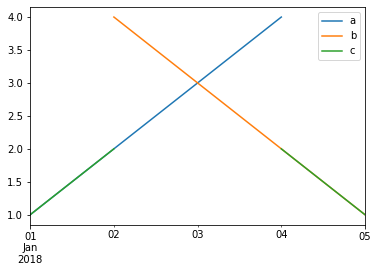

In [50]:
# Two ways of plotting
ts.plot()

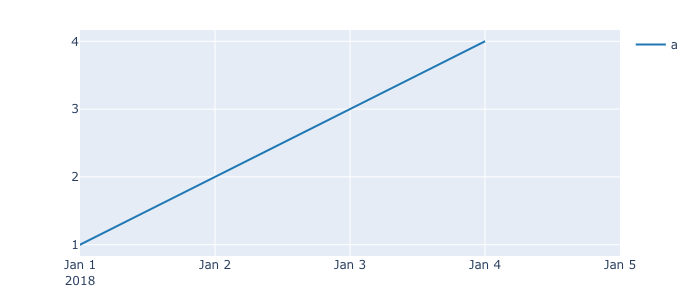

In [51]:
ts['a'].vbt.timeseries.plot().show_png()

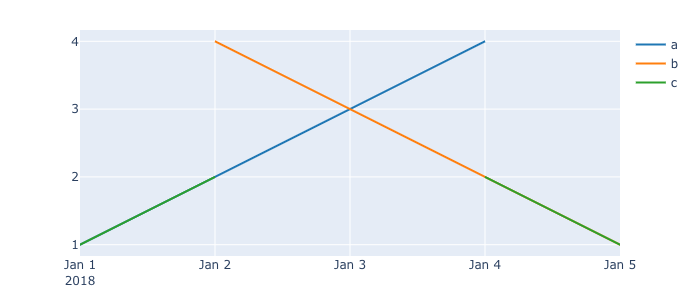

In [52]:
ts.vbt.timeseries.plot().show_png()

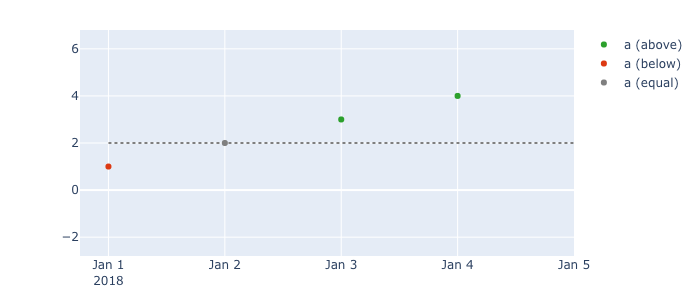

In [53]:
ts['a'].vbt.timeseries.plot_against(2).show_png()

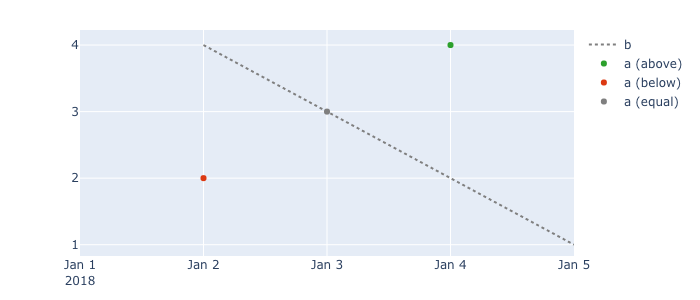

In [54]:
ts['a'].vbt.timeseries.plot_against(ts['b']).show_png()

## OHLCV

In [55]:
print(vbt.defaults.ohlcv['column_names'])

{'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}


In [56]:
try:
    ts.vbt.ohlcv.plot()
except Exception as e:
    print(e) # couldn't find default column names

'Open'


In [57]:
ohlcv_ts = pd.DataFrame({
    'open': [1, 2, 3], 
    'high': [1, 2, 3], 
    'low': [1, 2, 3], 
    'close': [1, 2, 3], 
    'volume': [1, 2, 3]
})

In [58]:
ohlcv_ts = pd.DataFrame(
    columns=['open', 'high', 'low', 'close', 'volume'],
    index=[datetime(2018, 1, 1) + timedelta(days=i) for i in range(10)]
)
ohlcv_ts['open'] = np.cumsum(np.random.uniform(-0.8, 1, size=(10,)))
ohlcv_ts['close'] = ohlcv_ts['open'] + np.random.uniform(-1, 1, size=(10,))
ohlcv_ts['high'] = ohlcv_ts['open'] + np.random.uniform(0, 1, size=(10,))
ohlcv_ts['low'] = ohlcv_ts['open'] - np.random.uniform(0, 1, size=(10,))
ohlcv_ts['volume'] = np.cumsum(np.random.uniform(-1, 1, size=(10,)))

print(ohlcv_ts)

                open      high       low     close    volume
2018-01-01 -0.371783 -0.249567 -1.050143  0.331155 -0.949240
2018-01-02 -0.872261 -0.820550 -1.279109 -1.536343 -0.351283
2018-01-03 -0.787437 -0.311247 -1.112421 -0.504045 -0.850516
2018-01-04 -1.123571 -0.258032 -1.551324 -1.268156 -0.906371
2018-01-05 -1.163046 -0.745076 -1.843235 -2.152684 -1.620085
2018-01-06 -1.860052 -1.409471 -2.352343 -1.260271 -2.255403
2018-01-07 -1.682325 -1.496508 -2.437416 -1.219597 -2.454653
2018-01-08 -1.840357 -1.593446 -1.872728 -1.078833 -2.846155
2018-01-09 -2.067851 -1.851648 -2.307843 -2.174168 -2.782897
2018-01-10 -1.535938 -0.860218 -2.298333 -0.546377 -1.900873


In [59]:
try:
    ohlcv_ts.vbt.ohlcv.plot()
except Exception as e:
    print(e) # still couldn't find default column names

'Open'


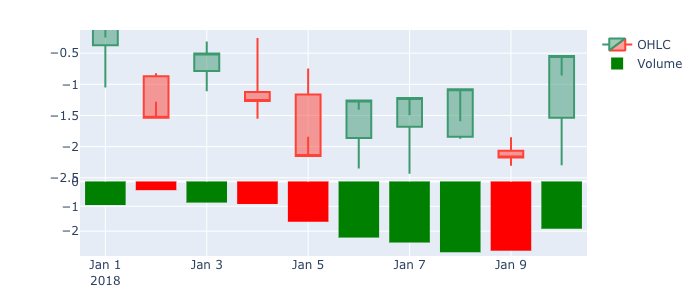

In [60]:
# Specify them manually
ohlcv_ts.vbt.ohlcv(column_names={
    'open': 'open', 
    'high': 'high', 
    'low': 'low', 
    'close': 'close', 
    'volume': 'volume'
}).plot().show_png()

In [61]:
# Or by changing the defaults
vbt.defaults.ohlcv['column_names'] = {
    'open': 'open', 
    'high': 'high', 
    'low': 'low', 
    'close': 'close', 
    'volume': 'volume'
}

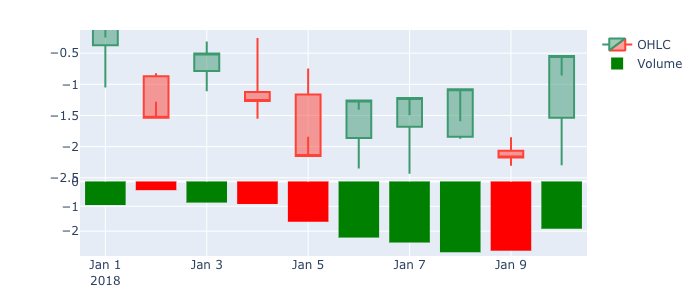

In [62]:
ohlcv_ts.vbt.ohlcv.plot().show_png()